# Plot hospital admission related to common infection

This notebook aggregates all infection-related hospital admission data and plots the counts and percentages of them.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from datetime import date
from operator import attrgetter
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- functions and read data

In [2]:
def process_infection_data(data_infection, infection_name):
    # add variables for incdt, prevl, no_abs, abs for uti
    data_infection.loc[((data_infection[infection_name+'_ab_date'].isnull() == True) & (data_infection['incdt_'+infection_name+'_date'] == 0)), 'no_ab_incdt'] = 1
    data_infection.loc[((data_infection[infection_name+'_ab_date'].isnull() == False) & (data_infection['incdt_'+infection_name+'_date'] == 0)), 'ab_incdt'] = 1
    data_infection.loc[((data_infection[infection_name+'_ab_date'].isnull() == True) & (data_infection['incdt_'+infection_name+'_date'] == 1)), 'no_ab_prevl'] = 1
    data_infection.loc[((data_infection[infection_name+'_ab_date'].isnull() == False) & (data_infection['incdt_'+infection_name+'_date'] == 1)), 'ab_prevl'] = 1

    data_infection.loc[((data_infection[infection_name+'_ab_date'].isnull() == True) & (data_infection['incdt_'+infection_name+'_date'] == 0) & (data_infection['event_'+infection_name+'_admitted'] == 1)), 'hosp_no_ab_incdt'] = 1
    data_infection.loc[((data_infection[infection_name+'_ab_date'].isnull() == False) & (data_infection['incdt_'+infection_name+'_date'] == 0) & (data_infection['event_'+infection_name+'_admitted'] == 1)), 'hosp_ab_incdt'] = 1
    data_infection.loc[((data_infection[infection_name+'_ab_date'].isnull() == True) & (data_infection['incdt_'+infection_name+'_date'] == 1) & (data_infection['event_'+infection_name+'_admitted'] == 1)), 'hosp_no_ab_prevl'] = 1
    data_infection.loc[((data_infection[infection_name+'_ab_date'].isnull() == False) & (data_infection['incdt_'+infection_name+'_date'] == 1) & (data_infection['event_'+infection_name+'_admitted'] == 1)), 'hosp_ab_prevl'] = 1

    data_infection['infection'] = infection_name
    data_infection['event_admitted'] = data_infection['event_'+infection_name+'_admitted']
    data_infection = data_infection[['infection', 'event_admitted', 'date', 'no_ab_incdt', 'ab_incdt', 'no_ab_prevl', 'ab_prevl', 'hosp_no_ab_incdt', 'hosp_ab_incdt', 'hosp_no_ab_prevl', 'hosp_ab_prevl']]
    
    return data_infection

In [3]:
def create_lineplot(y, var, title, ylabel, ax1):
    sns.lineplot(x='date', y=y, 
            hue=var, 
            data=data_groupby_date_infectoion,
            markers=True,
            # markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'],
            # plot_kws=dict(alpha=0.5),
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel(ylabel)
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [4]:
def create_lineplot_nolegend(y, var, title, ylabel, ax1):
    sns.lineplot(x='date', y=y, 
            hue=var, 
            data=data_groupby_date_infectoion,
            markers=True,
            # markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'],
            # plot_kws=dict(alpha=0.5),
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel('Date')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)
    ax1.legend([],[], frameon=False)

In [5]:
#transfer data from other notebooks
data_lrti = pd.read_csv(f'../output/hospitalisation_prediction_lrti/data_lrti.csv')
data_urti = pd.read_csv(f'../output/hospitalisation_prediction_urti/data_urti.csv')
data_uti = pd.read_csv(f'../output/hospitalisation_prediction_uti/data_uti.csv')
data_sinusitis = pd.read_csv(f'../output/hospitalisation_prediction_sinusitis/data_sinusitis.csv')
data_otmedia = pd.read_csv(f'../output/hospitalisation_prediction_otmedia/data_otmedia.csv')
data_ot_externa = pd.read_csv(f'../output/hospitalisation_prediction_ot_externa/data_ot_externa.csv')
data_pneumonia = pd.read_csv(f'../output/hospitalisation_prediction_pneumonia/data_pneumonia.csv')
data_cough = pd.read_csv(f'../output/hospitalisation_prediction_cough/data_cough.csv')
data_cough_cold = pd.read_csv(f'../output/hospitalisation_prediction_cough_cold/data_cough_cold.csv')
data_throat = pd.read_csv(f'../output/hospitalisation_prediction_throat/data_throat.csv')

#select relevant columns of data
data_uti = data_uti[['date', 'event_uti_admitted', 'uti_ab_date', 'incdt_uti_date']]
data_urti = data_urti[['date', 'event_urti_admitted', 'urti_ab_date', 'incdt_urti_date']]
data_lrti = data_lrti[['date', 'event_lrti_admitted', 'lrti_ab_date', 'incdt_lrti_date']]
data_sinusitis = data_sinusitis[['date', 'event_sinusitis_admitted', 'sinusitis_ab_date', 'incdt_sinusitis_date']]
data_otmedia = data_otmedia[['date', 'event_otmedia_admitted', 'otmedia_ab_date', 'incdt_otmedia_date']]
data_ot_externa = data_ot_externa[['date', 'event_ot_externa_admitted', 'ot_externa_ab_date', 'incdt_ot_externa_date']]
data_pneumonia = data_pneumonia[['date', 'event_pneumonia_admitted', 'pneumonia_ab_date', 'incdt_pneumonia_date']]
data_cough = data_cough[['date', 'event_cough_admitted', 'cough_ab_date', 'incdt_cough_date']]
data_cough_cold = data_cough_cold[['date', 'event_cough_cold_admitted', 'cough_cold_ab_date', 'incdt_cough_cold_date']]
data_throat = data_throat[['date', 'event_throat_admitted', 'throat_ab_date', 'incdt_throat_date']]

# data_uti.head()

## 1- process and group-by data, and save them

In [6]:
# process data of all infections
data_uti = process_infection_data(data_uti, 'uti')
data_urti = process_infection_data(data_urti, 'urti')
data_lrti = process_infection_data(data_lrti, 'lrti')
data_sinusitis = process_infection_data(data_sinusitis, 'sinusitis')
data_otmedia = process_infection_data(data_otmedia, 'otmedia')
data_ot_externa = process_infection_data(data_ot_externa, 'ot_externa')
data_pneumonia = process_infection_data(data_pneumonia, 'pneumonia')
data_cough = process_infection_data(data_cough, 'cough')
data_cough_cold = process_infection_data(data_cough_cold, 'cough_cold')
data_throat = process_infection_data(data_throat, 'throat')

In [9]:
#combine all data together
data = data_uti.append([data_urti, data_lrti, data_sinusitis, data_otmedia, data_ot_externa, data_pneumonia, data_cough, data_cough_cold, data_throat], ignore_index=True)
# data

#groupby date and infection type
data_groupby_date_infectoion = data.groupby(['date', 'infection'], as_index=False).sum()
# data_groupby_date_infectoion

#drop any events equal or less than 5
data_groupby_date_infectoion = data_groupby_date_infectoion[data_groupby_date_infectoion.event_admitted > 5]
data_groupby_date_infectoion

date   infection  event_admitted  no_ab_incdt  ab_incdt  no_ab_prevl  \
0    2019-01       cough            17.0       2285.0     260.0        242.0   
1    2019-01  cough_cold            16.0       2349.0     250.0        245.0   
2    2019-01        lrti            11.0       2238.0     257.0        233.0   
3    2019-01  ot_externa            20.0       2347.0     240.0        249.0   
4    2019-01     otmedia            21.0       2188.0     246.0        246.0   
..       ...         ...             ...          ...       ...          ...   
425  2022-07   pneumonia            23.0       1708.0     190.0        212.0   
426  2022-07   sinusitis            16.0       1654.0     177.0        165.0   
427  2022-07      throat            13.0       1733.0     193.0        183.0   
428  2022-07        urti            18.0       1712.0     169.0        202.0   
429  2022-07         uti            16.0       1729.0     178.0        178.0   

     ab_prevl  hosp_no_ab_incdt  hosp_ab_incdt  hosp_no_ab_prevl  \
0        26.0              13.0            2.0               2.0   
1        30.0              15.0            0.0               1.0   
2        29.0              11.0            0.0               0.0   
3        32.0              13.0            2.0               5.0   
4        31.0              17.0            0.0               4.0   
..        ...               ...            ...               ...   
425      35.0              17.0            3.0               3.0   
426      25.0              16.0            0.0               0.0   
427      25.0              11.0            1.0               1.0   
428      23.0              14.0            3.0               1.0   
429      18.0              12.0            1.0               3.0   

     hosp_ab_prevl  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
..             ...  
425            0.0  
426            0.0  
427            0.0  
428            0.0  
429            0.0  

[430 rows x 11 columns]

In [11]:
#calculate total infections and percentages of each hospitalisation
data_groupby_date_infectoion['total_cases'] = data_groupby_date_infectoion['no_ab_incdt'] + data_groupby_date_infectoion['ab_incdt'] + data_groupby_date_infectoion['no_ab_prevl'] + data_groupby_date_infectoion['ab_prevl']
data_groupby_date_infectoion['hosp_perc'] = (data_groupby_date_infectoion['event_admitted'] / data_groupby_date_infectoion['total_cases'])*100
data_groupby_date_infectoion['hosp_perc_no_ab_incdt'] = (data_groupby_date_infectoion['hosp_no_ab_incdt'] / data_groupby_date_infectoion['no_ab_incdt'])*100
data_groupby_date_infectoion['hosp_perc_ab_incdt'] = (data_groupby_date_infectoion['hosp_ab_incdt'] / data_groupby_date_infectoion['ab_incdt'])*100
data_groupby_date_infectoion['hosp_perc_no_ab_prevl'] = (data_groupby_date_infectoion['hosp_no_ab_prevl'] / data_groupby_date_infectoion['no_ab_prevl'])*100
data_groupby_date_infectoion['hosp_perc_ab_prevl'] = (data_groupby_date_infectoion['hosp_ab_prevl'] / data_groupby_date_infectoion['ab_prevl'])*100
# data_groupby_date_infectoion

In [12]:
# save data
data_groupby_date_infectoion_date_event_inf = data_groupby_date_infectoion[['date',	'infection', 'event_admitted']]
data_groupby_date_infectoion_date_event_inf.to_csv('../output/hosp_plots/data_groupby_date_infectoion_date_event_inf.csv', index=False)

## 2- plot counts and percentages

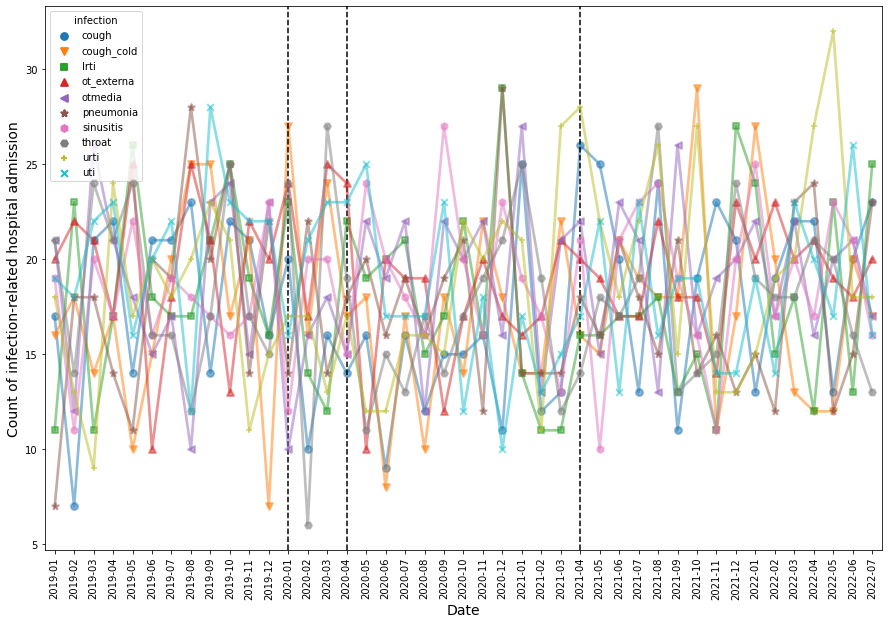

In [14]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_groupby_date_infectoion, y="event_admitted", x="date", hue="infection", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count of infection-related hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hosp_plots/hosp_count.jpg')
plt.show()

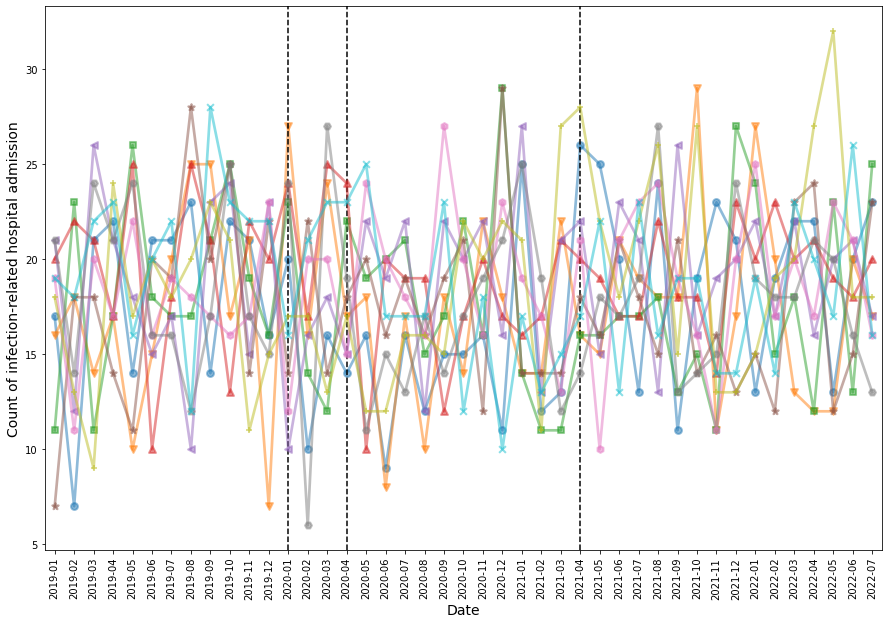

In [15]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_groupby_date_infectoion, y="event_admitted", x="date", hue="infection", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count of infection-related hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hosp_plots/hosp_count_nolegend.jpg')
plt.show()

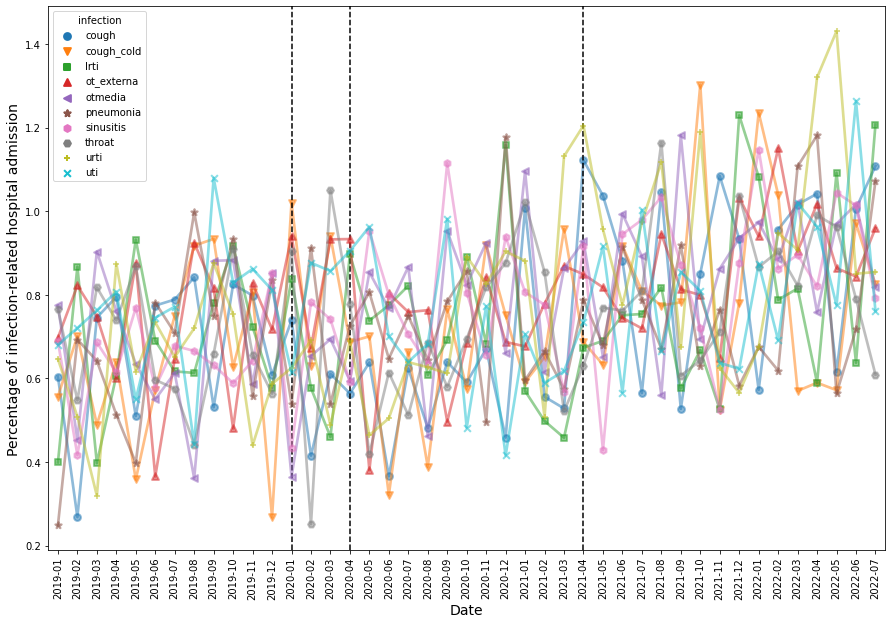

In [16]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_groupby_date_infectoion, y="hosp_perc", x="date", hue="infection", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of infection-related hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hosp_plots/hosp_percentage.jpg')
plt.show()

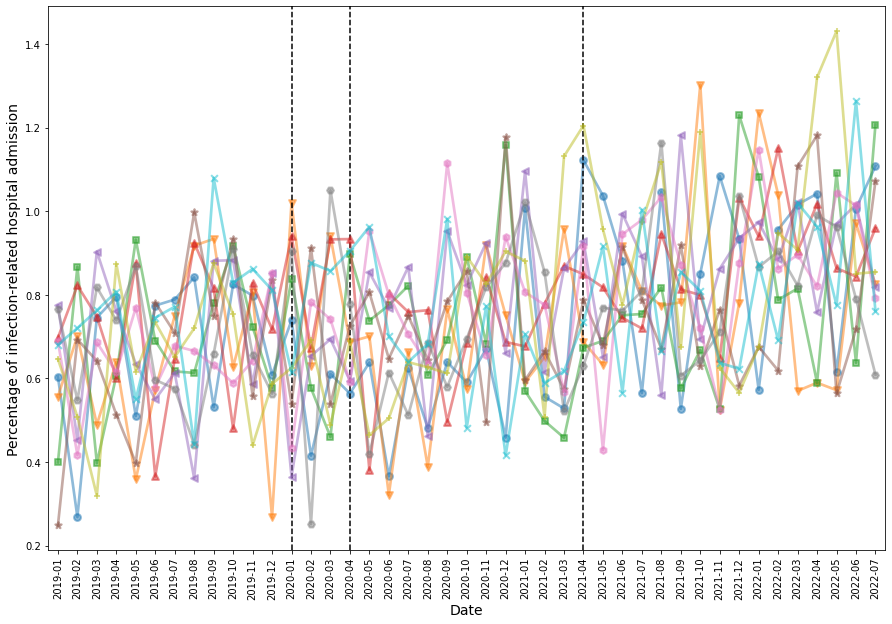

In [17]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_groupby_date_infectoion, y="hosp_perc", x="date", hue="infection", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of infection-related hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hosp_plots/hosp_percentage_nolegend.jpg')
plt.show()

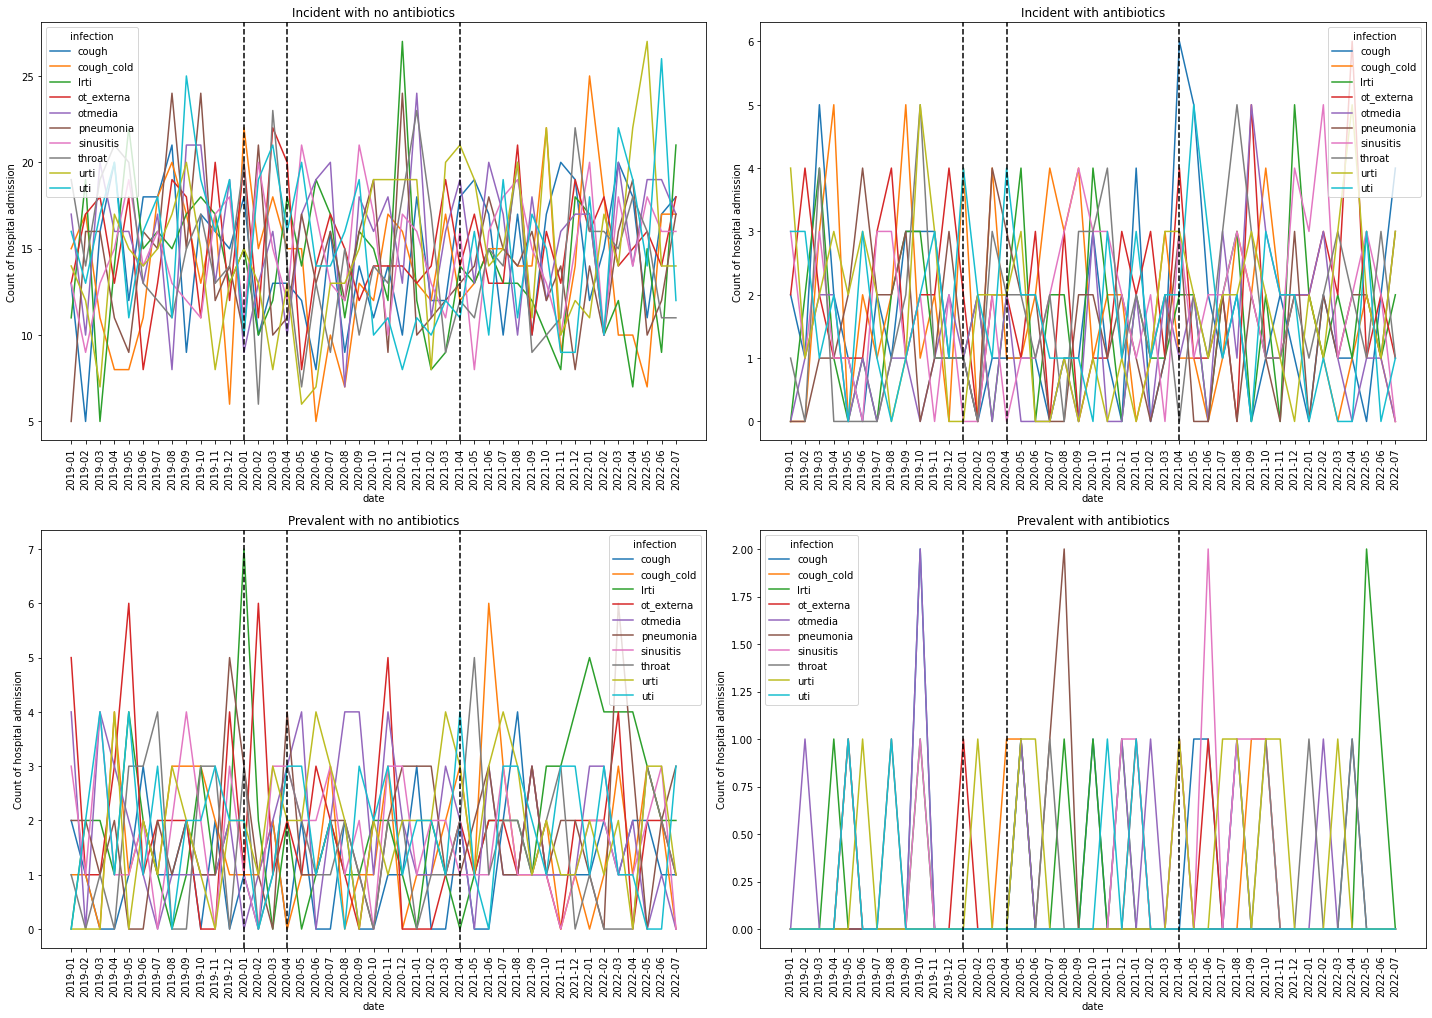

In [18]:
fig, axes = plt.subplots(2,2,
                        figsize=(20, 15)
                        )
create_lineplot('hosp_no_ab_incdt', 'infection', 'Incident with no antibiotics', 'Count of hospital admission', axes[0,0])
create_lineplot('hosp_ab_incdt', 'infection', 'Incident with antibiotics', 'Count of hospital admission', axes[0,1])
create_lineplot('hosp_no_ab_prevl', 'infection', 'Prevalent with no antibiotics', 'Count of hospital admission', axes[1,0])
create_lineplot('hosp_ab_prevl', 'infection', 'Prevalent with antibiotics', 'Count of hospital admission', axes[1,1])
# fig.delaxes(ax=axes[6,1])

fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hosp_plots/hosp_count_incdt_prevl_noabs_abs.jpg')
plt.show()

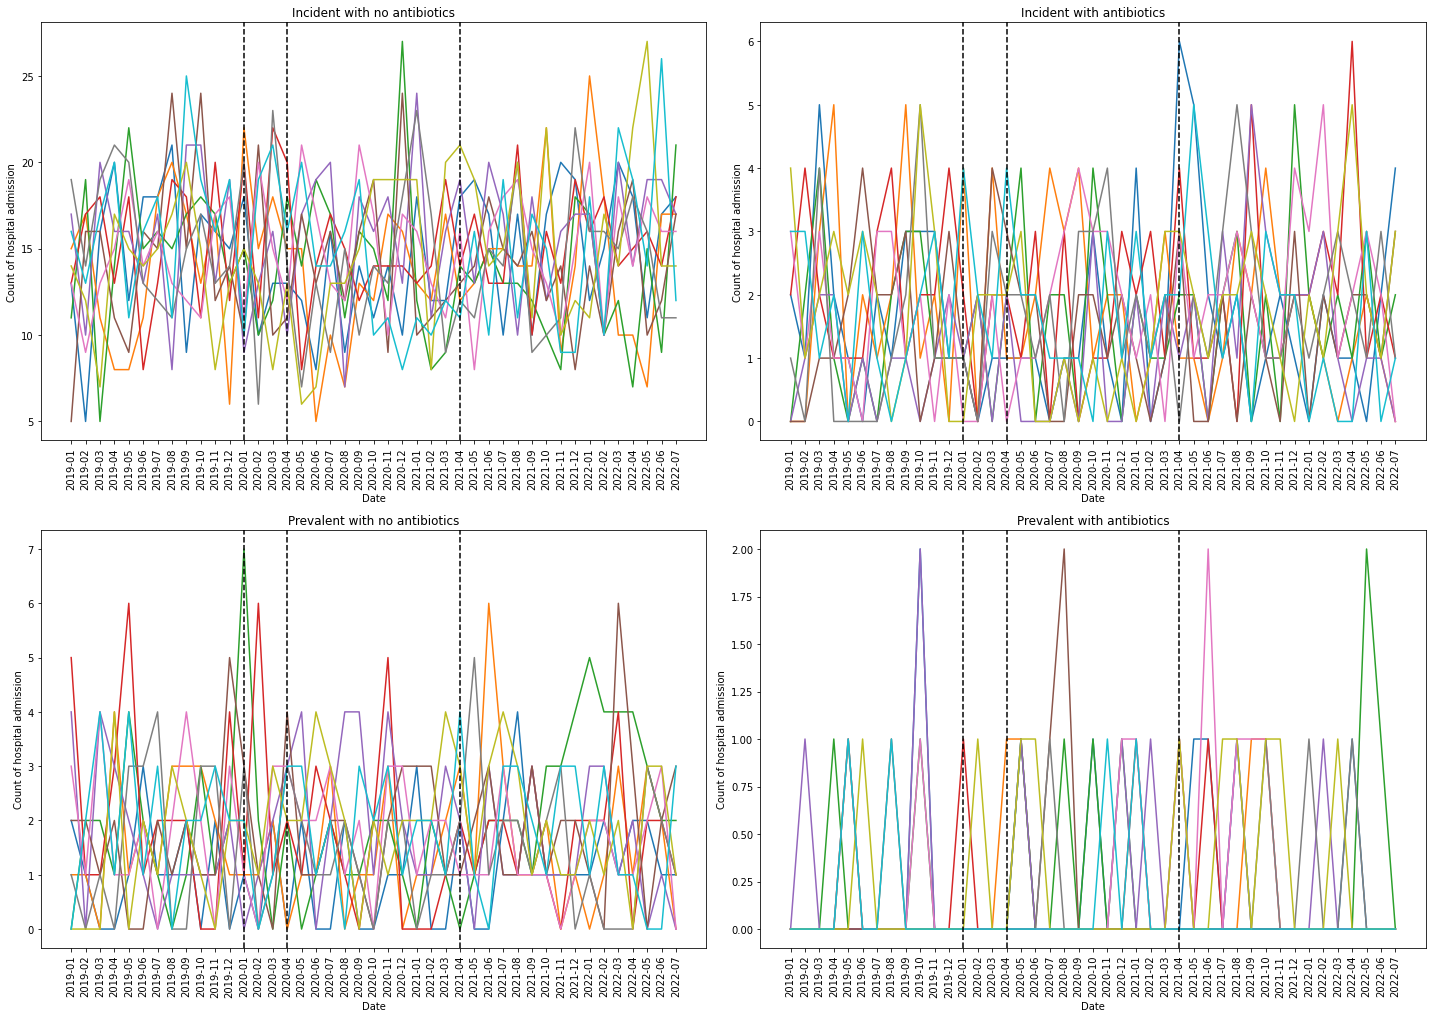

In [19]:
fig, axes = plt.subplots(2,2,
                        figsize=(20, 15)
                        )
create_lineplot_nolegend('hosp_no_ab_incdt', 'infection', 'Incident with no antibiotics', 'Count of hospital admission', axes[0,0])
create_lineplot_nolegend('hosp_ab_incdt', 'infection', 'Incident with antibiotics', 'Count of hospital admission', axes[0,1])
create_lineplot_nolegend('hosp_no_ab_prevl', 'infection', 'Prevalent with no antibiotics', 'Count of hospital admission', axes[1,0])
create_lineplot_nolegend('hosp_ab_prevl', 'infection', 'Prevalent with antibiotics', 'Count of hospital admission', axes[1,1])
# fig.delaxes(ax=axes[6,1])

fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hosp_plots/hosp_count_incdt_prevl_noabs_abs_nolegend.jpg')
plt.show()

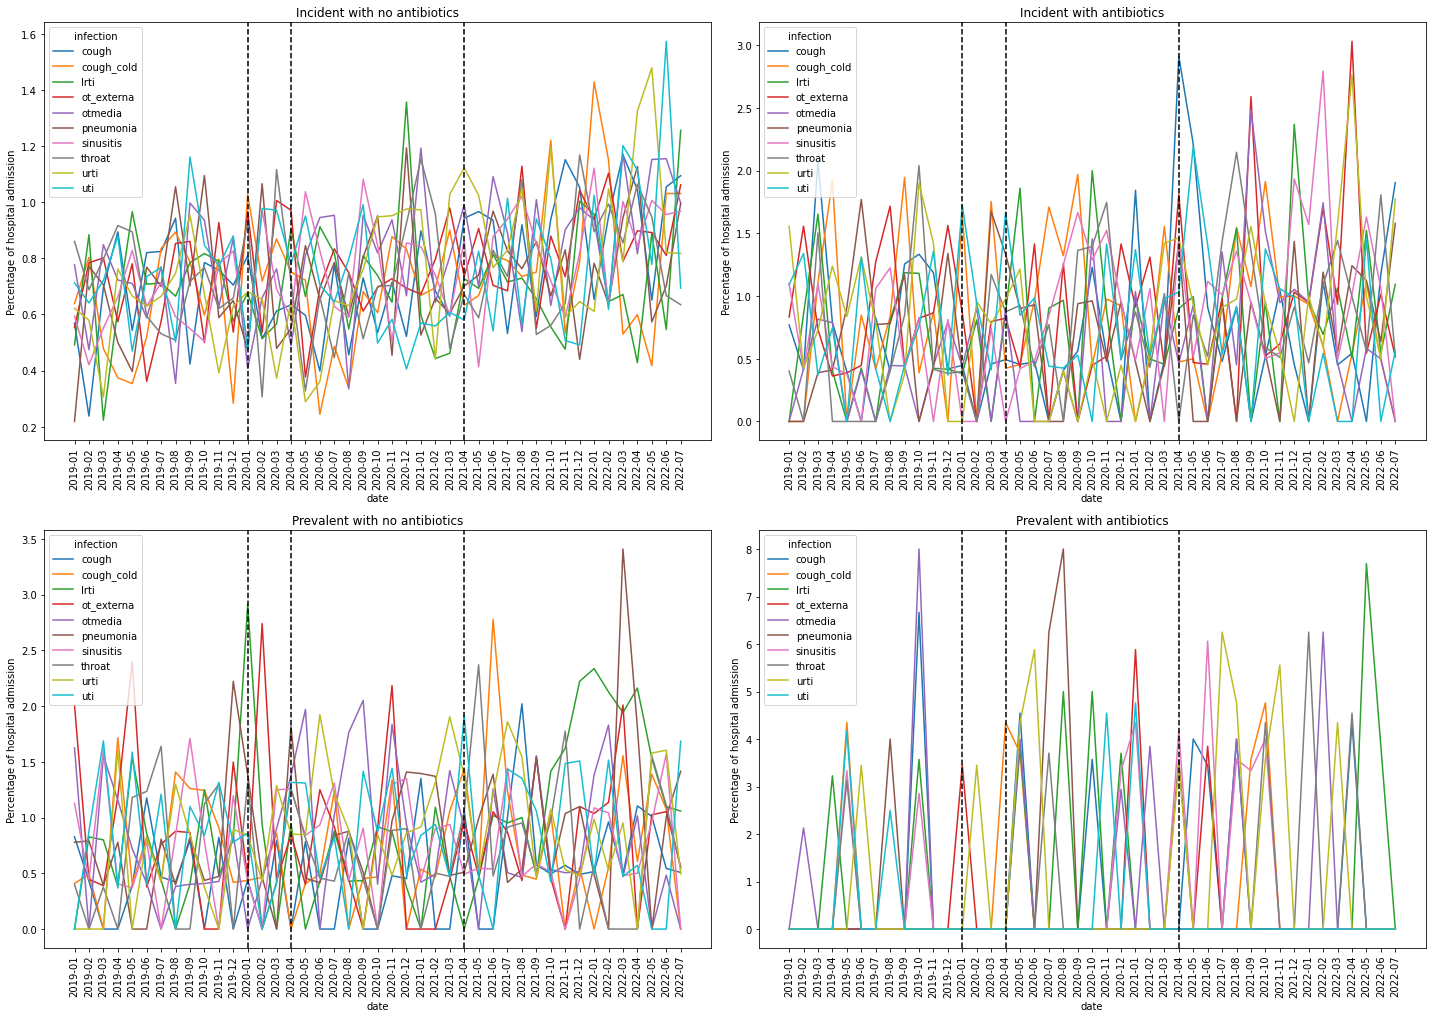

In [20]:
fig, axes = plt.subplots(2,2,
                        figsize=(20, 15)
                        )
create_lineplot('hosp_perc_no_ab_incdt', 'infection', 'Incident with no antibiotics', 'Percentage of hospital admission', axes[0,0])
create_lineplot('hosp_perc_ab_incdt', 'infection', 'Incident with antibiotics', 'Percentage of hospital admission', axes[0,1])
create_lineplot('hosp_perc_no_ab_prevl', 'infection', 'Prevalent with no antibiotics', 'Percentage of hospital admission', axes[1,0])
create_lineplot('hosp_perc_ab_prevl', 'infection', 'Prevalent with antibiotics', 'Percentage of hospital admission', axes[1,1])
# fig.delaxes(ax=axes[6,1])

fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hosp_plots/hosp_percentage_incdt_prevl_noabs_abs.jpg')
plt.show()

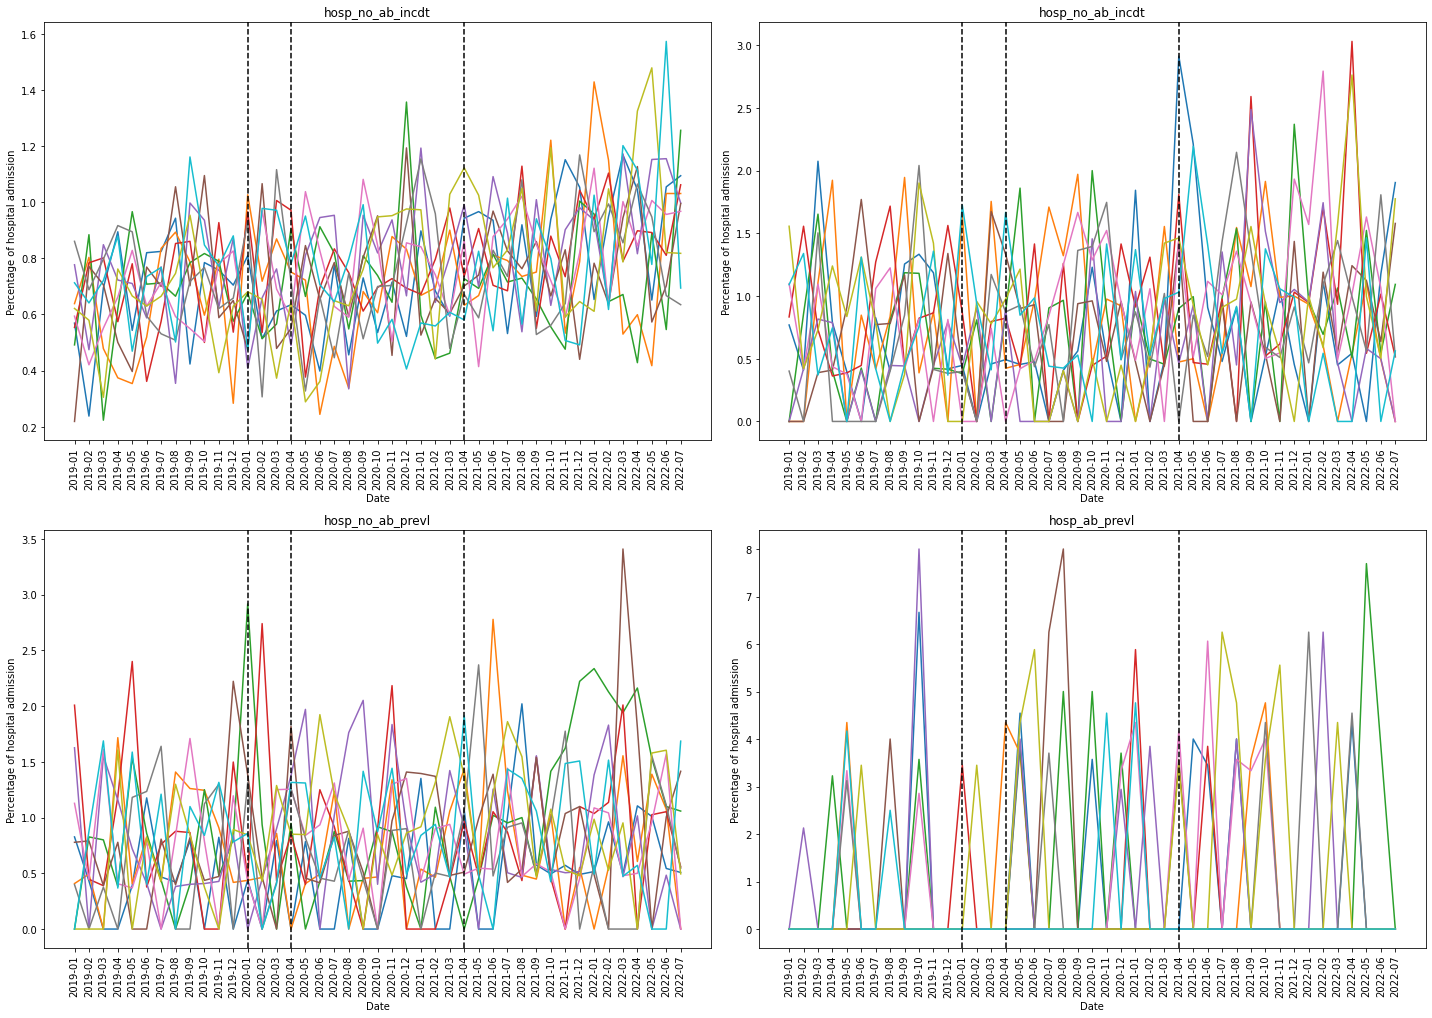

In [21]:
fig, axes = plt.subplots(2,2,
                        figsize=(20, 15)
                        )
create_lineplot_nolegend('hosp_perc_no_ab_incdt', 'infection', 'hosp_no_ab_incdt', 'Percentage of hospital admission', axes[0,0])
create_lineplot_nolegend('hosp_perc_ab_incdt', 'infection', 'hosp_no_ab_incdt', 'Percentage of hospital admission', axes[0,1])
create_lineplot_nolegend('hosp_perc_no_ab_prevl', 'infection', 'hosp_no_ab_prevl', 'Percentage of hospital admission', axes[1,0])
create_lineplot_nolegend('hosp_perc_ab_prevl', 'infection', 'hosp_ab_prevl', 'Percentage of hospital admission', axes[1,1])
# fig.delaxes(ax=axes[6,1])

fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hosp_plots/hosp_percentage_incdt_prevl_noabs_abs_nolegend.jpg')
plt.show()